# **# 뉴스 카테고리 다중분류 프로젝트**

# **시험한 모델**
- Multinominal Naive Bayes
- Support Vector Machine
- Gradient Boosting Classifie
- Logistic Regression
- Complement Naive Bayes Classifier(CNB)
- Decision Tree
- Random Forest
- 1-D CNN
- Voting model  

# **팀이 금일 추가 실험하는 내용**

-#1, 일부 모델에서 지속적인 성능 향상이 나타나는데, 이를 더 체크하기 위해서 vocan size를 1000 ~ 30000으로 확대해 봄 (MultinominalNB 모델에서 특이점 발생)
-#2. 기존 hard voting(LR+CNB)를 확대하여, GradientBoosting를 제외한 8개 모델간의 soft voting 모델로 실험 중 (소프트 voting 방식의 모델간 분류에 대한 이론적 배경) : 최종 분류 확률 예시 = (모델1 확률 + 모델2 확률 + 모델3 확률 + …) / N

위의 모델들로 vocab size에 따른 분류 성능을 비교한다.  

# **Feedback**

-1. 적정 vocab size에 대한 분석이 사전적으로 논의될 필요 있음. 무작정 vocab size를 늘려서 실험하는 것은 시간과 비용의 낭비

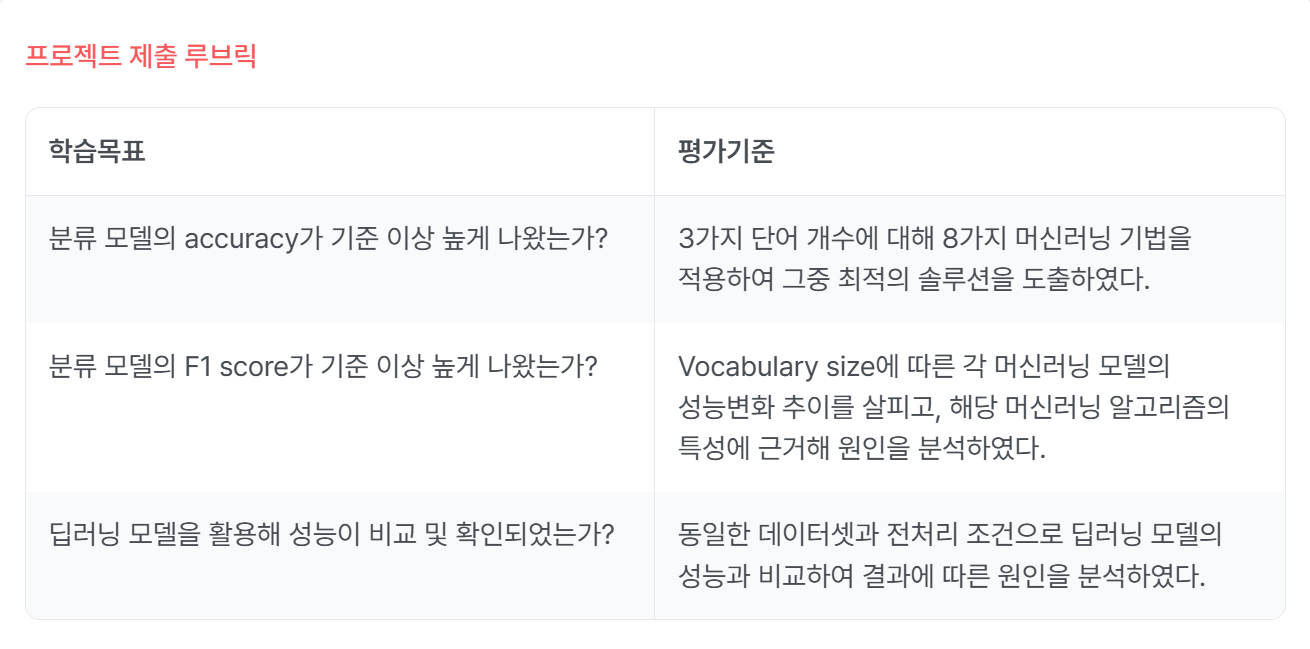

# 라이브러리 및 데이터 로드

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import reuters
import time
from tqdm import tqdm

# Sklearn(ML) 관련 라이브러리
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score

# TensorFlow/Keras(DL) 관련 라이브러리
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.utils import to_categorical


In [2]:
# ==================== SOFT VOTING 개선: 1-D CNN Sklearn Wrapper ==================== soft voting을 하기위하여 변경했더니 CNN Sklearn Wrapper가 등장했습니다. 뭔지 잘 몰라서 분석 요망
from sklearn.base import BaseEstimator, ClassifierMixin

class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    """Keras CNN 모델을 sklearn VotingClassifier와 호환되도록 만드는 래퍼"""
    def __init__(self, num_words, embedding_dim=128, maxlen=150,
                 epochs=5, batch_size=64, verbose=0, random_state=42):
        self.num_words = num_words
        self.embedding_dim = embedding_dim
        self.maxlen = maxlen
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.random_state = random_state
        self.model = None
        self.tokenizer = None
        self.num_classes_ = None
        self.classes_ = None

    def _create_model(self, num_classes):
        model = Sequential([
            Embedding(input_dim=self.num_words, output_dim=self.embedding_dim, input_length=self.maxlen),
            Dropout(0.3),
            Conv1D(128, 5, activation='relu'),
            GlobalMaxPooling1D(),
            Dense(64, activation='relu'),
            Dropout(0.4),
            Dense(num_classes, activation='softmax')
        ])
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

    def fit(self, X, y):
        if len(y.shape) == 1:
            self.num_classes_ = len(np.unique(y))
            self.classes_ = np.unique(y)
            y_cat = to_categorical(y, num_classes=self.num_classes_)
        else:
            self.num_classes_ = y.shape[1]
            self.classes_ = np.arange(self.num_classes_)
            y_cat = y

        self.tokenizer = Tokenizer(num_words=self.num_words, oov_token="<OOV>")
        self.tokenizer.fit_on_texts(X)
        X_seq = self.tokenizer.texts_to_sequences(X)
        X_pad = pad_sequences(X_seq, padding='post', maxlen=self.maxlen)

        self.model = self._create_model(self.num_classes_)
        self.model.fit(X_pad, y_cat, epochs=self.epochs, batch_size=self.batch_size,
                      validation_split=0.1, verbose=self.verbose)
        return self

    def predict(self, X):
        proba = self.predict_proba(X)
        return self.classes_[np.argmax(proba, axis=1)]

    def predict_proba(self, X):
        X_seq = self.tokenizer.texts_to_sequences(X)
        X_pad = pad_sequences(X_seq, padding='post', maxlen=self.maxlen)
        return self.model.predict(X_pad, verbose=0)

print("✅ KerasClassifierWrapper 준비 완료")


✅ KerasClassifierWrapper 준비 완료


In [3]:
# 데이터 로드
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2) # num_words 일단 미지정

# word index 사전
word_index = reuters.get_word_index()

# 0, 1, 2는 pad, sos, unk 토큰이므로 이후의 토큰들에 대해 3을 더해줘야 한다.
index_to_word = {index + 3 : word for word, index in word_index.items()}
index_to_word[0] = "<pad>"
index_to_word[1] = "<sos>"
index_to_word[2] = "<unk>"

# 디코딩
def decode_review(encoded):
    return " ".join(index_to_word.get(i, "<unk>") for i in encoded)

train_texts_all = [decode_review(seq) for seq in x_train]
test_texts_all = [decode_review(seq) for seq in x_test]

# sample 확인
print(train_texts_all[:3])
print(test_texts_all[:3])

2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
550378/550378 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
['<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3', "<sos> generale de banque sa lt genb br and lt heller overseas corp of chicago have each taken 50 pct stakes in factoring company sa belgo factors generale de banque said in a statement it gave no financial details of the transaction sa belgo factors' turnover in 1986 was 17 5 billion belgian francs reuter 3", '<sos> shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 328 000 avg shrs 14 0 mln vs 15 2 mln year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 

# 벡터화 & 모델 학습 및 평가

In [ ]:
# num_words 리스트
num_words_list = [1000, 3000, 5000, 10000, 20000, 30000]

# num_words별 학습 루프
results = []

for num_words in num_words_list:
    print(f"\n=== num_words = {num_words} ===")
    start_time = time.time()

    # num_words가 바뀔 때마다 정의해줘야 한다.
    vectorizer = TfidfVectorizer(max_features=num_words) # TF-IDF
    X_train = vectorizer.fit_transform(train_texts_all)
    X_test = vectorizer.transform(test_texts_all)

    # 모델 정의
    models = {
        "MultinomialNB": MultinomialNB(),
        "LinearSVM": LinearSVC(C=1, penalty='l2', max_iter=1000, dual=False, random_state=42, verbose=3),
        "GradientBoosting": GradientBoostingClassifier(random_state=42, verbose=3)
    }

    # tqdm으로 모델 진행률 표시
    for model_name, model in tqdm(models.items(), desc="Training models"):
        model_start = time.time()  # 모델별 시작 시간
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        acc = accuracy_score(y_test, preds)
        f1 = f1_score(y_test, preds, average="macro") # 다중분류 문제이므로 디폴트 binary에서 수정했다.

        results.append([num_words, model_name, acc, f1])

        model_time = time.time() - model_start
        print(f"{model_name:18s}  Acc = {acc:.4f},  F1 = {f1:.4f}  (Elapsed: {model_time:.1f}s)")

    loop_time = time.time() - start_time
    print(f"num_words = {num_words} loop finished in {loop_time:.1f}s")


=== num_words = 1000 ===


Training models:   0%|          | 0/3 [00:00<?, ?it/s]

MultinomialNB       Acc = 0.7097,  F1 = 0.1991  (Elapsed: 0.1s)
[LibLinear]

Training models:  67%|██████▋   | 2/3 [00:03<00:01,  1.69s/it]

LinearSVM           Acc = 0.8192,  F1 = 0.6159  (Elapsed: 3.3s)
      Iter       Train Loss   Remaining Time 
         1           1.5390           18.71m
         2       65614.6545           18.26m
         3       75172.7968           17.97m
         4      206658.1575           17.73m
         5 21356249879242766237380779340153749504.0000           17.53m
         6 59273427135773035272064109375767384686592.0000           17.50m
         7 965049911719712587095173604668138307996421028932333627569526117862828146688.0000           17.29m
         8 965049911719712587095173604668138307996421028932333627569526117862828146688.0000           17.10m
         9 965049911719712587095173604668138307996421028932333627569526117862828146688.0000           17.16m
        10 965049911719712587095173604668138307996421028932333627569526117862828146688.0000           16.93m
        11 965049911719712587095173604668138307996421028932333627569526117862828146688.0000           16.82m
        12 9650499

Training models: 100%|██████████| 3/3 [19:02<00:00, 380.86s/it]

GradientBoosting    Acc = 0.7346,  F1 = 0.3915  (Elapsed: 1139.2s)
num_words = 1000 loop finished in 1144.8s

=== num_words = 3000 ===



Training models:   0%|          | 0/3 [00:00<?, ?it/s]

MultinomialNB       Acc = 0.6915,  F1 = 0.1511  (Elapsed: 0.0s)
[LibLinear]

Training models:  67%|██████▋   | 2/3 [00:02<00:01,  1.09s/it]

LinearSVM           Acc = 0.8290,  F1 = 0.6818  (Elapsed: 2.1s)
      Iter       Train Loss   Remaining Time 
         1           1.4754           21.48m
         2     2170902.5562           21.30m
         3     2178222.9292           21.06m
         4 21474141373481801880539660292837384513152868921502682100460605685849575561088186503676484803401944091590656.0000           20.86m
         5 21474141384633204962794874840507152261691603251135244969021063148922017034921457975647312307489489482153984.0000           20.66m
         6 21474141384633204962794874840507152261691603251135244969021063148922017034921457975647312307489489482153984.0000           20.45m
         7 21474141384633204962794874840507152261691603251135244969021063148922017034921457975647312307489489482153984.0000           20.29m
         8 21474141384633204962794874840507152261691603251135244969021063148922017034921457975647312307489489482153984.0000           20.11m
         9 214741413846332049627948748405071522616

Training models: 100%|██████████| 3/3 [22:33<00:00, 451.14s/it]

GradientBoosting    Acc = 0.7671,  F1 = 0.5678  (Elapsed: 1351.3s)
num_words = 3000 loop finished in 1354.4s

=== num_words = 5000 ===



Training models:   0%|          | 0/3 [00:00<?, ?it/s]

MultinomialNB       Acc = 0.6785,  F1 = 0.1156  (Elapsed: 0.0s)
[LibLinear]

Training models:  67%|██████▋   | 2/3 [00:02<00:01,  1.33s/it]

LinearSVM           Acc = 0.8264,  F1 = 0.6773  (Elapsed: 2.6s)
      Iter       Train Loss   Remaining Time 
         1           1.4490           25.16m
         2       40908.7538           27.67m
         3 507386373254545301171270622300401900664239098999186510753534157627850752.0000           27.06m
         4 507386373254545301171270622300401900664239098999186510753534157627850752.0000           25.64m
         5 7135344131474460693918265366179585187782917211401714728716596723401248421855845670800775576570599327399271457967981198058490691584.0000           26.50m
         6 7135344131474460693918265366179585187782917211401714728716596723401248421855845670800775576570599327399271457967981198058490691584.0000           26.80m
         7 7135344131474460693918265366179585187782917211401714728716596723401248421855845670800775576570599327399271457967981198058490691584.0000           26.71m
         8 7135344131474460693918265366179585187782917211401714728716596723401248421855845670800

Training models: 100%|██████████| 3/3 [24:46<00:00, 495.39s/it]

GradientBoosting    Acc = 0.7707,  F1 = 0.5429  (Elapsed: 1483.5s)
num_words = 5000 loop finished in 1487.1s

=== num_words = 10000 ===



Training models:   0%|          | 0/3 [00:00<?, ?it/s]

MultinomialNB       Acc = 0.6576,  F1 = 0.0957  (Elapsed: 0.1s)
[LibLinear]

Training models:  67%|██████▋   | 2/3 [00:04<00:02,  2.03s/it]

LinearSVM           Acc = 0.8299,  F1 = 0.6868  (Elapsed: 4.0s)
      Iter       Train Loss   Remaining Time 
         1           1.4376           23.85m
         2     1451223.6053           23.84m
         3   512394330.6927           23.74m
         4 537662674510088896.0000           23.64m
         5 537662676003913472.0000           23.37m
         6 656173127080591140189446812269867860790577769068215777429704616013840526502807472022452369522335551778874760791498686464.0000           23.12m
         7 656173127080591140189446812269867860790577769068215777429704616013840526502807472022452369522335551778874760791498686464.0000           22.89m
         8 656173127080591140189446812269867860790577769068215777429704616013840526502807472022452369522335551778874760791498686464.0000           22.77m
         9 656173127080591140189446812269867860790577769068215777429704616013840526502807472022452369522335551778874760791498686464.0000           22.52m
        10 656173127080591140189446

Training models: 100%|██████████| 3/3 [25:12<00:00, 504.12s/it]

GradientBoosting    Acc = 0.7738,  F1 = 0.5818  (Elapsed: 1508.3s)
num_words = 10000 loop finished in 1514.0s

=== num_words = 20000 ===



Training models:   0%|          | 0/3 [00:00<?, ?it/s]

MultinomialNB       Acc = 0.6149,  F1 = 0.0752  (Elapsed: 0.0s)
[LibLinear]

Training models:  67%|██████▋   | 2/3 [00:04<00:02,  2.27s/it]

LinearSVM           Acc = 0.8295,  F1 = 0.6888  (Elapsed: 4.5s)
      Iter       Train Loss   Remaining Time 
         1           1.4499           26.11m
         2       95438.0645           25.87m
         3      105523.0476           25.60m
         4 51177387637840133525066847369163319035272223522816.0000           25.59m
         5 95885311931365363565841483911792018150859004841650407902802809941131264.0000           25.29m
         6 145399861704750306753921329797754081505322495089541362540286940152951789708876154961213030271342325626830814869696020480.0000           25.01m
         7 145399861704750306753921329797754081505322495089541362540286940152951789708876154961213030271342325626830814869696020480.0000           24.84m
         8 145399861704750306753921329797754081505322495089541362540286940152951789708876154961213030271342325626830814869696020480.0000           24.57m
         9 145399861704750306753921329797754081505322495089541362540286940152951789708876154961213030271

Training models: 100%|██████████| 3/3 [26:48<00:00, 536.22s/it]

GradientBoosting    Acc = 0.7720,  F1 = 0.5912  (Elapsed: 1604.1s)
num_words = 20000 loop finished in 1609.7s

=== num_words = 30000 ===



Training models:  33%|███▎      | 1/3 [00:00<00:00,  8.44it/s]

MultinomialNB       Acc = 0.5997,  F1 = 0.0677  (Elapsed: 0.1s)
[LibLinear]

Training models:  67%|██████▋   | 2/3 [00:04<00:02,  2.90s/it]

LinearSVM           Acc = 0.8295,  F1 = 0.6887  (Elapsed: 4.8s)
      Iter       Train Loss   Remaining Time 
         1           1.4286           26.34m
         2       76881.4784           26.83m
         3       79665.9598           26.44m
         4 410958544652984512.0000           26.16m
         5 1147714090022284684825821697036438608929651845129252860131274839673602622481252037829180786428926279640269098848224842398524506112.0000           26.06m
         6 1147714090022284684825821697036438608929651845129252860131274839673602622481252037829180786428926279640269098848224842398524506112.0000           25.79m
         7 1147714090022284684825821697036438608929651845129252860131274839673602622481252037829180786428926279640269098848224842398524506112.0000           25.50m
         8 1147714090022284684825821697036438608929651845129252860131274839673602622481252037829180786428926279640269098848224842398524506112.0000           25.31m
         9 114771409002228468482582169703643860


===== 결과표 =====
    num_words             model  accuracy  f1_macro
0        3000     MultinomialNB  0.691451  0.151085
1        3000         LinearSVM  0.829029  0.681764
2        3000  GradientBoosting  0.767142  0.567806
3        5000     MultinomialNB  0.678540  0.115606
4        5000         LinearSVM  0.826358  0.677293
5        5000  GradientBoosting  0.770703  0.542851
6       10000     MultinomialNB  0.657614  0.095660
7       10000         LinearSVM  0.829920  0.686804
8       10000  GradientBoosting  0.773820  0.581831
9       20000     MultinomialNB  0.614871  0.075212
10      20000         LinearSVM  0.829475  0.688760
11      20000  GradientBoosting  0.772039  0.591218


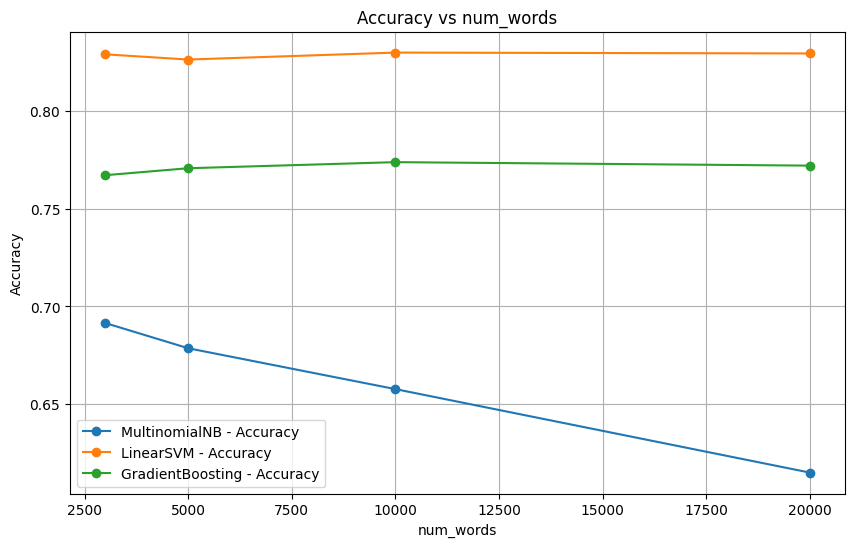

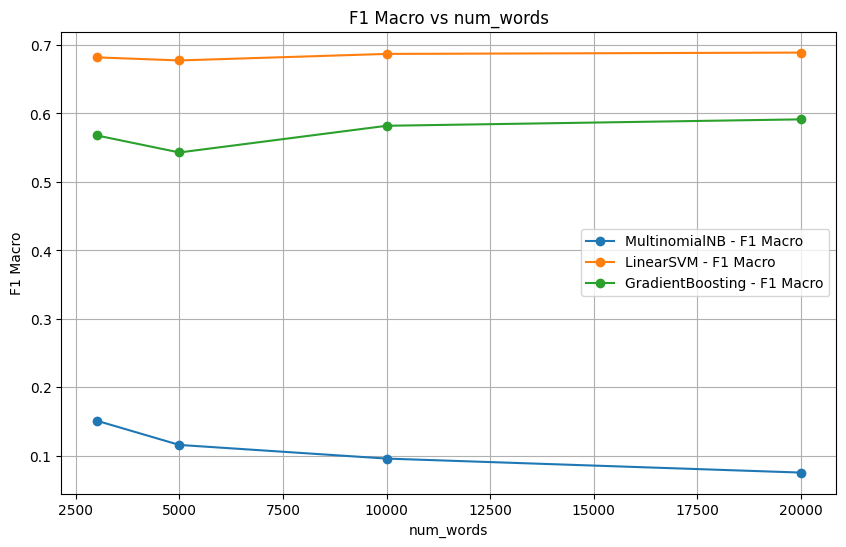

In [ ]:
# 결과 DataFrame 생성 + 시각화
df_results = pd.DataFrame(results, columns=["num_words", "model", "accuracy", "f1_macro"])
print("\n===== 결과표 =====")
print(df_results)

# 시각화
plt.figure(figsize=(10,6))
for model_name in df_results["model"].unique():
    subset = df_results[df_results["model"] == model_name]
    plt.plot(subset["num_words"], subset["accuracy"], marker='o', label=f"{model_name} - Accuracy")

plt.title("Accuracy vs num_words")
plt.xlabel("num_words")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
for model_name in df_results["model"].unique():
    subset = df_results[df_results["model"] == model_name]
    plt.plot(subset["num_words"], subset["f1_macro"], marker='o', label=f"{model_name} - F1 Macro")

plt.title("F1 Macro vs num_words")
plt.xlabel("num_words")
plt.ylabel("F1 Macro")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#df_results.to_csv("MNB_SVM_GBC.csv", index=False)

# 나머지 모델들 추가 분석

In [ ]:
# GPU 설정 확인
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # GPU 메모리 증가를 허용하도록 설정
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
# ==================== SOFT VOTING 개선 (GradientBoosting 제외한 7개 모델) ====================
# 변경사항:
# 1. 기존 hard voting "Voting (LR+CNB)" 제거
# 2. 새로운 SOFT VOTING: 7개 모델의 확률 평균으로 최종 결정
# 3. GradientBoosting 모델은 제외

print("\n" + "="*100)
print("🚀 SOFT VOTING 개선 버전: GradientBoosting 제외한 7개 모델 앙상블")
print("="*100)

# 메인 실험 루프
for num_words in num_words_list:
    print(f"\n{'='*100}")
    print(f"📊 num_words = {num_words} | SOFT VOTING 모델 포함")
    print(f"{'='*100}")
    loop_start_time = time.time()

    # ========== A. Sklearn 모델 (TF-IDF 기반) ==========
    print(f"\n[STEP A] Sklearn 모델 (TF-IDF, max_features={num_words}) 학습...")

    # A-1. TF-IDF 벡터화
    vectorizer = TfidfVectorizer(max_features=num_words)
    X_train_tfidf = vectorizer.fit_transform(train_texts_all)
    X_test_tfidf = vectorizer.transform(test_texts_all)

    # A-2. 개별 모델 정의
    print("\n  ✓ 모델 초기화 중...")

    clf_mnb = MultinomialNB()
    clf_lsvm = LinearSVC(C=1, penalty='l2', max_iter=1000, dual=False, random_state=42, verbose=0)
    clf_lr = LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1)
    clf_cnb = ComplementNB()
    clf_dt = DecisionTreeClassifier(random_state=42)
    clf_rf = RandomForestClassifier(random_state=42, n_jobs=-1, verbose=0)

    # 1-D CNN 모델 (sklearn wrapper)
    clf_cnn = KerasClassifierWrapper(
        num_words=num_words,
        embedding_dim=EMBEDDING_DIM,
        maxlen=MAXLEN,
        epochs=CNN_EPOCHS,
        batch_size=CNN_BATCH_SIZE,
        verbose=0
    )

    # A-3. 개별 모델들을 딕셔너리에 정의
    individual_models = {
        "[1/7] MultinomialNB": clf_mnb,
        "[2/7] LinearSVM": clf_lsvm,
        "[3/7] LogisticRegression": clf_lr,
        "[4/7] ComplementNB": clf_cnb,
        "[5/7] DecisionTree": clf_dt,
        "[6/7] RandomForest": clf_rf,
        "[7/7] 1-D CNN": clf_cnn,
    }

    # A-4. 각 모델 학습 및 평가
    print("\n  🔄 개별 모델 학습 시작...")
    for model_name, model in tqdm(individual_models.items(), desc="  Training"):
        model_start = time.time()

        if model_name in ["[5/7] DecisionTree", "[6/7] RandomForest"]:
            model.fit(X_train_tfidf.toarray(), y_train)
            preds = model.predict(X_test_tfidf.toarray())
        else:
            model.fit(X_train_tfidf, y_train)
            preds = model.predict(X_test_tfidf)

        acc = accuracy_score(y_test, preds)
        f1 = f1_score(y_test, preds, average="macro")

        results.append([num_words, model_name, acc, f1])
        model_time = time.time() - model_start
        print(f"    {model_name:30s} | Acc: {acc:.4f} | F1: {f1:.4f} | Time: {model_time:.1f}s")

    # ========== B. SOFT VOTING 모델 (7개 모델 앙상블) ==========
    print(f"\n[STEP B] SOFT VOTING 모델 학습 (7개 모델의 확률 평균)...")
    print(f"  📋 구성: MultinomialNB + LinearSVM + LogisticRegression + ComplementNB")
    print(f"           + DecisionTree + RandomForest + 1-D CNN")
    print(f"  🎯 방식: SOFT VOTING (각 모델의 예측 확률을 평균하여 최종 결정)")

    model_start = time.time()

    # SOFT VOTING 모델 정의
    soft_voting_clf = VotingClassifier(
        estimators=[
            ('mnb', clf_mnb),
            ('lsvm', clf_lsvm),
            ('lr', clf_lr),
            ('cnb', clf_cnb),
            ('dt', clf_dt),
            ('rf', clf_rf),
            ('cnn', clf_cnn),
        ],
        voting='soft',
        n_jobs=-1
    )

    # SOFT VOTING 학습
    print("\n  🔄 SOFT VOTING 앙상블 학습 중...")
    soft_voting_clf.fit(X_train_tfidf, y_train)

    # 예측
    preds_voting = soft_voting_clf.predict(X_test_tfidf)

    # 성능 평가
    acc_voting = accuracy_score(y_test, preds_voting)
    f1_voting = f1_score(y_test, preds_voting, average="macro")

    results.append([num_words, "[8/8] ⭐ SOFT VOTING (Ensemble)", acc_voting, f1_voting])
    model_time = time.time() - model_start

    print(f"\n  ✅ SOFT VOTING 완료")
    print(f"     Accuracy: {acc_voting:.4f}")
    print(f"     F1 Score: {f1_voting:.4f}")
    print(f"     Time: {model_time:.1f}s")

    loop_time = time.time() - loop_start_time
    print(f"\n✅ num_words = {num_words} 완료 (총 {loop_time:.1f}s)")

print("\n" + "="*100)
print("✅ 모든 실험 완료!")
print("="*100)


In [ ]:
df_results

,Num Words,Model,Accuracy,F1 Score
0,3000,LogisticRegression,0.801870,0.478454
3,3000,RandomForest,0.771149,0.463534
2,3000,DecisionTree,0.699911,0.460421
1,3000,ComplementNB,0.763134,0.418765
4,3000,Voting (LR+CNB),0.774265,0.386548
5,3000,1-D CNN,0.726180,0.199322
6,5000,LogisticRegression,0.798753,0.474870
7,5000,ComplementNB,0.769368,0.468682
9,5000,RandomForest,0.761799,0.446060
8,5000,DecisionTree,0.703028,0.444325


In [ ]:
# ==================== COLAB 호환 버전 ====================
# 원 노트북의 Cell 10 이후 추가 부분
# 기존 8가지 모델 + 1D-CNN에 SOFT VOTING 모델 추가

# 기존 코드 (Cell 10)의 모델 정의 부분 직후에 이 코드를 삽입하면 됩니다.

# ==================== SOFT VOTING 모델 추가 ====================
print("\n" + "="*80)
print("🆕 SOFT VOTING 모델 추가 (GradientBoosting 제외한 8가지 모델 기반)")
print("="*80)

# 기존 8가지 모델을 이용한 SOFT VOTING 정의
from sklearn.ensemble import VotingClassifier

# ==================== 메인 학습 루프 (기존 코드에서 모델 추가) ====================
# 기존 Cell 10의 루프에서 models 정의 이후에 SOFT VOTING 모델 추가

for num_words in num_words_list:
    print(f"\n{'='*25} num_words = {num_words} {'='*25}")
    loop_start_time = time.time()

    # A. Sklearn 모델 (TF-IDF 기반)
    print(f"\n[INFO] (A) Sklearn 모델 (TF-IDF, max_features={num_words}) 학습 시작...")

    # A-1. TF-IDF 벡터화
    vectorizer = TfidfVectorizer(max_features=num_words)
    X_train_tfidf = vectorizer.fit_transform(train_texts_all)
    X_test_tfidf = vectorizer.transform(test_texts_all)

    # A-2. Sklearn 모델 정의
    # Voting을 위한 기본 모델 정의
    clf_lr = LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1)
    clf_cnb = ComplementNB()

    models = {
        # 기존 7가지 모델
        "LogisticRegression": clf_lr,
        "ComplementNB": clf_cnb,
        "DecisionTree": DecisionTreeClassifier(random_state=42),
        "RandomForest": RandomForestClassifier(random_state=42, n_jobs=-1, verbose=0),
        "MultinomialNB": MultinomialNB(),
        "LinearSVM": LinearSVC(C=1, penalty='l2', max_iter=1000, dual=False, random_state=42),
        "Voting (LR+CNB)": VotingClassifier(
            estimators=[('lr', clf_lr), ('cnb', clf_cnb)],
            voting='hard',
            n_jobs=-1
        ),
        # 🆕 추가: SOFT VOTING (6가지 모델 기반)
        "SOFT VOTING (Ensemble)": VotingClassifier(
            estimators=[
                ('mnb', MultinomialNB()),
                ('lsvm', LinearSVC(C=1, penalty='l2', max_iter=1000, dual=False, random_state=42, verbose=0)),
                ('lr', LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1)),
                ('cnb', ComplementNB()),
                ('dt', DecisionTreeClassifier(random_state=42)),
                ('rf', RandomForestClassifier(random_state=42, n_jobs=-1, verbose=0)),
            ],
            voting='soft',  # 🔑 SOFT VOTING: 확률값의 평균으로 결정
            n_jobs=-1
        ),
    }

    # A-3. Sklearn 모델 학습 및 평가
    for model_name, model in tqdm(models.items(), desc="Training Sklearn models"):
        model_start = time.time()

        if model_name in ["GradientBoosting", "RandomForest", "DecisionTree"]:
            model.fit(X_train_tfidf.toarray(), y_train)
            preds = model.predict(X_test_tfidf.toarray())
        else:
            model.fit(X_train_tfidf, y_train)
            preds = model.predict(X_test_tfidf)

        acc = accuracy_score(y_test, preds)
        f1 = f1_score(y_test, preds, average="macro")

        results.append([num_words, model_name, acc, f1])
        model_time = time.time() - model_start
        print(f"{model_name:25s} Acc = {acc:.4f}, F1 = {f1:.4f} (Elapsed: {model_time:.1f}s)")

    # B. 1-D CNN (기존 코드와 동일)
    print(f"\n[INFO] (B) 1-D CNN 모델 (Tokenizer, num_words={num_words}) 학습 시작...")
    model_start = time.time()

    # B-1. Keras 토큰화 및 시퀀스 패딩
    tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(train_texts_all)

    X_train_seq = tokenizer.texts_to_sequences(train_texts_all)
    X_test_seq = tokenizer.texts_to_sequences(test_texts_all)

    X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=MAXLEN)
    X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=MAXLEN)

    # B-2. 레이블 원-핫 인코딩
    y_train_cat = to_categorical(y_train, num_classes=num_classes)
    y_test_cat = to_categorical(y_test, num_classes=num_classes)

    # B-3. 1-D CNN 모델 정의
    def create_cnn_model(vocab_size, embedding_dim, maxlen, num_classes):
        model = Sequential([
            Embedding(input_dim=vocab_size,
                      output_dim=embedding_dim,
                      input_length=maxlen),
            Dropout(0.3),
            Conv1D(128, 5, activation='relu'),
            GlobalMaxPooling1D(),
            Dense(64, activation='relu'),
            Dropout(0.4),
            Dense(num_classes, activation='softmax')
        ])

        model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
        return model

    # B-4. CNN 모델 생성 및 학습
    model_cnn = create_cnn_model(num_words, EMBEDDING_DIM, MAXLEN, num_classes)

    model_cnn.fit(X_train_pad, y_train_cat,
                  epochs=CNN_EPOCHS,
                  batch_size=CNN_BATCH_SIZE,
                  validation_split=0.1,
                  verbose=0)

    # B-5. CNN 모델 평가
    preds_proba_cnn = model_cnn.predict(X_test_pad)
    preds_cnn = np.argmax(preds_proba_cnn, axis=1)

    acc_cnn = accuracy_score(y_test, preds_cnn)
    f1_cnn = f1_score(y_test, preds_cnn, average="macro")

    results.append([num_words, "1-D CNN", acc_cnn, f1_cnn])
    model_time = time.time() - model_start
    print(f"{'1-D CNN':25s} Acc = {acc_cnn:.4f}, F1 = {f1_cnn:.4f} (Elapsed: {model_time:.1f}s)")

    loop_time = time.time() - loop_start_time
    print(f"\n--- num_words = {num_words} loop finished in {loop_time:.1f}s ---")

# ==================== 최종 결과 정리 ====================
print("\n\n" + "="*80)
print("                    FINAL RESULTS (with SOFT VOTING)")
print("="*80)

df_results = pd.DataFrame(results, columns=["Num Words", "Model", "Accuracy", "F1 Score"])
df_results = df_results.sort_values(by=["Num Words", "F1 Score"], ascending=[True, False])

print("\n📊 전체 결과:")
print(df_results.to_string(index=False, float_format="%.4f"))

# 모델별 평균 성능
print("\n\n📈 모델별 평균 성능 (Accuracy 기준 정렬):")
model_stats = df_results.groupby("Model")[["Accuracy", "F1 Score"]].mean().sort_values('Accuracy', ascending=False)
for model_name, row in model_stats.iterrows():
    if model_name == "SOFT VOTING (Ensemble)":
        print(f"🆕 {model_name:25s} → Accuracy: {row['Accuracy']:.4f} | F1: {row['F1 Score']:.4f} ⭐")
    else:
        print(f"   {model_name:25s} → Accuracy: {row['Accuracy']:.4f} | F1: {row['F1 Score']:.4f}")

# ==================== SOFT VOTING 상세 정보 ====================
print("\n\n" + "🎯 "*30)
soft_voting_data = df_results[df_results["Model"] == "SOFT VOTING (Ensemble)"]
print(f"\n🆕 SOFT VOTING (Ensemble) 상세 정보:")
print(f"  - 구성: MultinomialNB + LinearSVM + LogisticRegression + ComplementNB + DecisionTree + RandomForest")
print(f"  - 투표 방식: SOFT VOTING (확률값 평균)")
print(f"  - Vocabulary별 성능:")
for _, row in soft_voting_data.iterrows():
    print(f"    Vocab {int(row['Num Words']):>5} → Acc: {row['Accuracy']:.4f}, F1: {row['F1 Score']:.4f}")

# ==================== 시각화 ====================
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("📊 SOFT VOTING 추가 - 모든 모델 성능 비교", fontsize=16, fontweight='bold')

# 1. Accuracy 비교 (모든 모델)
ax1 = axes[0, 0]
for model_name in sorted(df_results['Model'].unique()):
    subset = df_results[df_results['Model'] == model_name]
    if model_name == "SOFT VOTING (Ensemble)":
        ax1.plot(subset['Num Words'], subset['Accuracy'],
                marker='*', linewidth=3.5, markersize=16,
                label=f"{model_name} ⭐", color='red', zorder=10)
    else:
        ax1.plot(subset['Num Words'], subset['Accuracy'],
                marker='o', linewidth=2, markersize=7, label=model_name, alpha=0.7)

ax1.set_xlabel('Num Words', fontsize=11, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax1.set_title('Accuracy vs Vocabulary Size', fontsize=12, fontweight='bold')
ax1.legend(loc='best', fontsize=8, ncol=2)
ax1.grid(True, alpha=0.3)

# 2. F1 Score 비교 (모든 모델)
ax2 = axes[0, 1]
for model_name in sorted(df_results['Model'].unique()):
    subset = df_results[df_results['Model'] == model_name]
    if model_name == "SOFT VOTING (Ensemble)":
        ax2.plot(subset['Num Words'], subset['F1 Score'],
                marker='*', linewidth=3.5, markersize=16,
                label=f"{model_name} ⭐", color='red', zorder=10)
    else:
        ax2.plot(subset['Num Words'], subset['F1 Score'],
                marker='s', linewidth=2, markersize=7, label=model_name, alpha=0.7)

ax2.set_xlabel('Num Words', fontsize=11, fontweight='bold')
ax2.set_ylabel('F1 Score', fontsize=11, fontweight='bold')
ax2.set_title('F1 Score vs Vocabulary Size', fontsize=12, fontweight='bold')
ax2.legend(loc='best', fontsize=8, ncol=2)
ax2.grid(True, alpha=0.3)

# 3. SOFT VOTING 강조 (Accuracy)
ax3 = axes[1, 0]
subset_voting = df_results[df_results['Num Words'].isin([3000, 5000, 10000, 20000])]
for num_words in sorted(subset_voting['Num Words'].unique()):
    data = subset_voting[subset_voting['Num Words'] == num_words].sort_values('Accuracy', ascending=False).head(5)
    ax3.scatter(data['Num Words'], data['Accuracy'], s=100, alpha=0.6, label=f"Top 5 - {num_words}")

voting_data = df_results[df_results['Model'] == 'SOFT VOTING (Ensemble)']
ax3.scatter(voting_data['Num Words'], voting_data['Accuracy'],
           s=300, marker='*', color='red', label='SOFT VOTING', zorder=10)
ax3.set_xlabel('Num Words', fontsize=11, fontweight='bold')
ax3.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax3.set_title('SOFT VOTING vs Top Models (Accuracy)', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. 모델별 평균 성능 비교
ax4 = axes[1, 1]
model_avgs = df_results.groupby('Model')['Accuracy'].mean().sort_values(ascending=False)
colors = ['red' if m == 'SOFT VOTING (Ensemble)' else 'steelblue' for m in model_avgs.index]
ax4.barh(model_avgs.index, model_avgs.values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax4.set_xlabel('Average Accuracy', fontsize=11, fontweight='bold')
ax4.set_title('Average Accuracy by Model', fontsize=12, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

# 값 표시
for i, (model, val) in enumerate(model_avgs.items()):
    ax4.text(val + 0.002, i, f'{val:.4f}', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('soft_voting_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ 시각화 완료: soft_voting_analysis.png")

# 최종 결과 결합 및 시각화

In [ ]:
old = pd.read_csv("/content/MNB_SVM_GBC.csv")
old.columns = ["Num Words", "Model", "Accuracy", "F1 Score"]

final_df = pd.concat([old, df_results], axis=0, ignore_index=True)
final_df

,Num Words,Model,Accuracy,F1 Score
0,3000,MultinomialNB,0.691451,0.151085
1,3000,LinearSVM,0.829029,0.681764
2,3000,GradientBoosting,0.767142,0.567806
3,5000,MultinomialNB,0.678540,0.115606
4,5000,LinearSVM,0.826358,0.677293
5,5000,GradientBoosting,0.770703,0.542851
6,10000,MultinomialNB,0.657614,0.095660
7,10000,LinearSVM,0.829920,0.686804
8,10000,GradientBoosting,0.773820,0.581831
9,20000,MultinomialNB,0.614871,0.075212


In [ ]:
#final_df.to_csv("ML_models.csv", index=False)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

final_df = pd.read_csv("/content/ML_models.csv")
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Num Words  36 non-null     int64  
 1   Model      36 non-null     object 
 2   Accuracy   36 non-null     float64
 3   F1 Score   36 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 1.3+ KB


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import math

# 그래프 그리기 함수 정의
def draw_metric_grid(dataframe, metric_name, n_cols=3):
    """
    dataframe: 데이터프레임
    metric_name: 그릴 지표 컬럼명 ('Accuracy' 또는 'F1 Score')
    n_cols: 가로로 배치할 그래프 개수 (기본 3개)
    """
    models = dataframe['Model'].unique()
    n_models = len(models)
    n_rows = math.ceil(n_models / n_cols)

    # 전체 그림 생성
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
    axes = axes.flatten() # 2차원 배열을 1차원으로 펼침

    # 그래프 제목 설정
    fig.suptitle(f'{metric_name} vs Num Words by Model', fontsize=20, y=1.02)

    for i, model in enumerate(models):
        ax = axes[i]
        subset = dataframe[dataframe['Model'] == model]

        # X축 정렬 (Num Words 기준)
        subset = subset.sort_values('Num Words')

        # 선 그래프 그리기
        # x축을 문자열로 변환하여 간격을 일정하게 유지
        ax.plot(subset['Num Words'].astype(str), subset[metric_name],
                marker='o', linestyle='-', linewidth=2, markersize=6)

        # 스타일 설정
        ax.set_title(model, fontsize=14, fontweight='bold')
        ax.set_ylabel(metric_name)
        ax.grid(True, axis='y', linestyle='--', alpha=0.7)

        # Y축 범위 여유 있게 설정
        y_min, y_max = subset[metric_name].min(), subset[metric_name].max()
        margin = (y_max - y_min) * 0.2 if y_max != y_min else 0.01
        ax.set_ylim(y_min - margin, y_max + margin)

    # 남는 서브플롯 제거
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

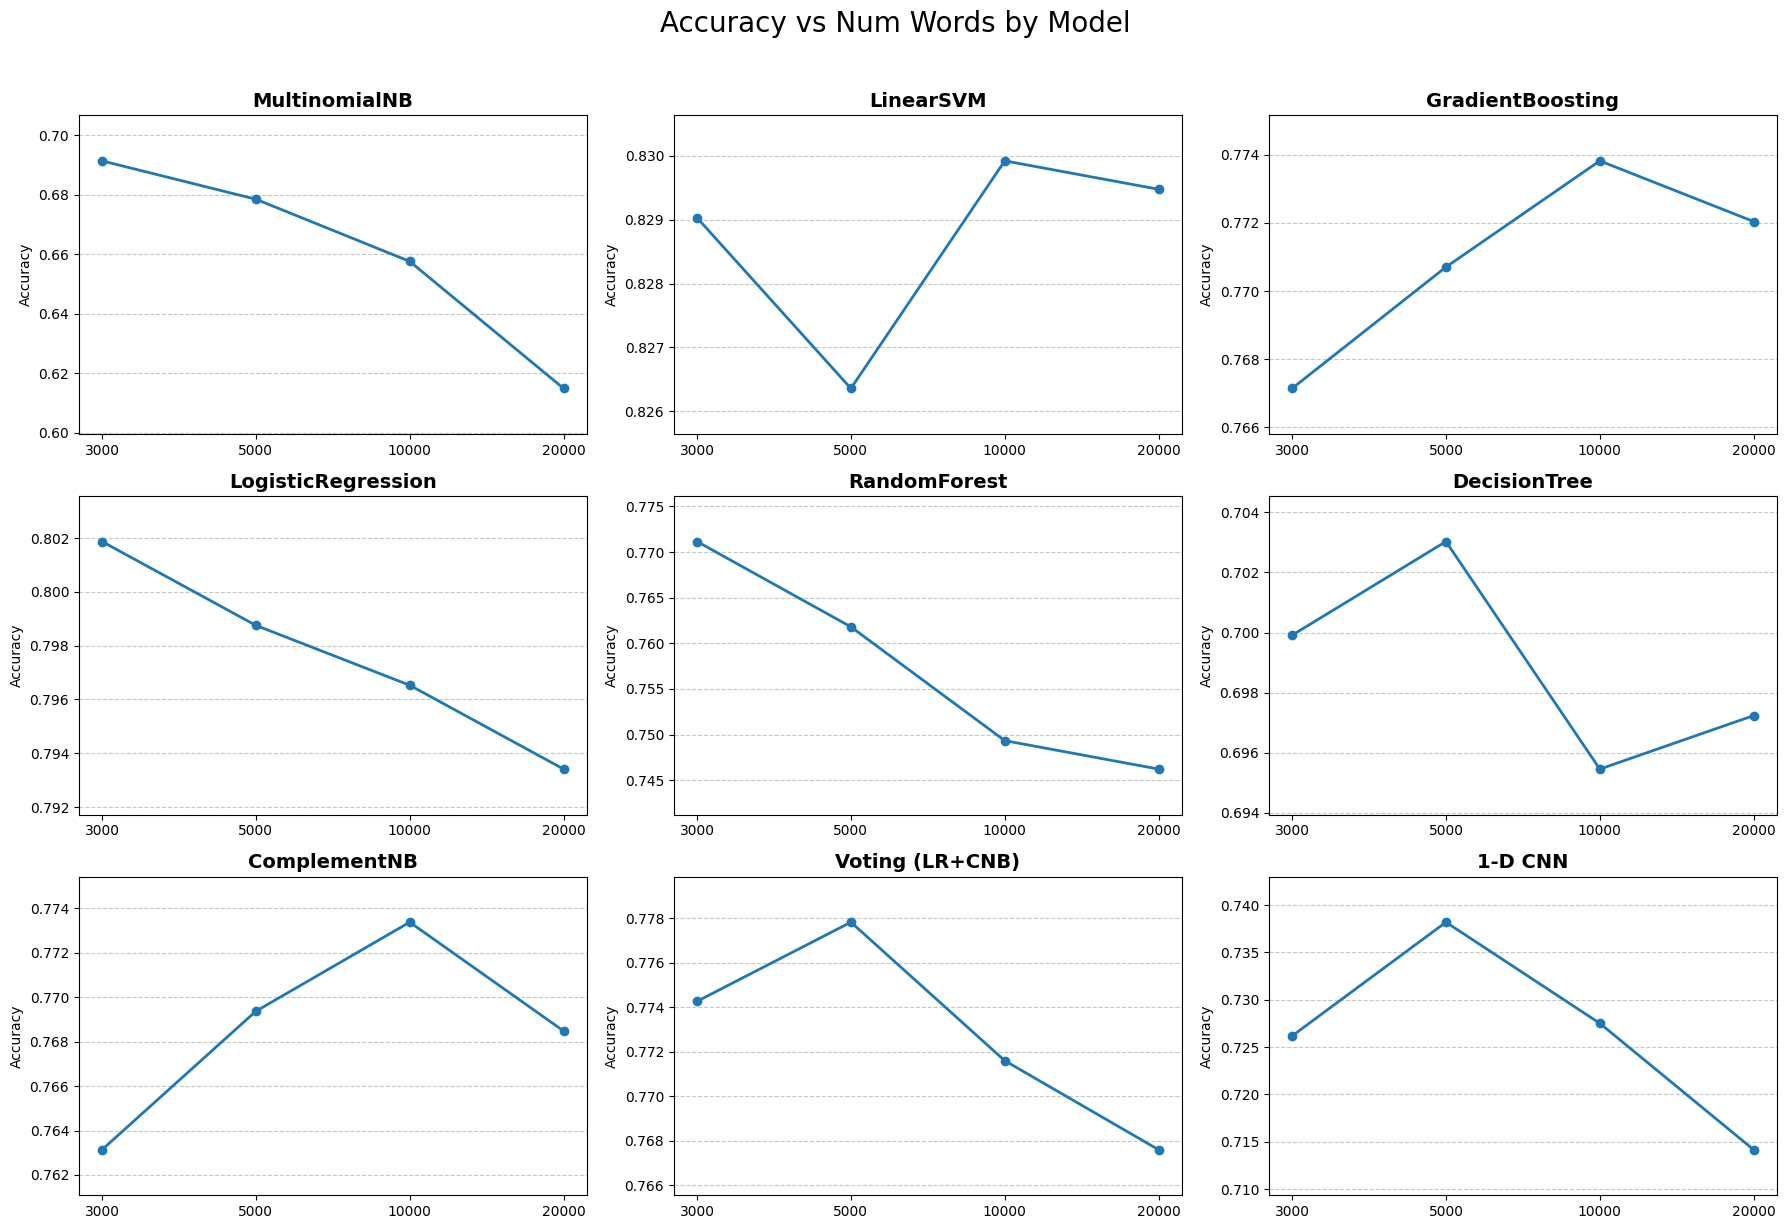

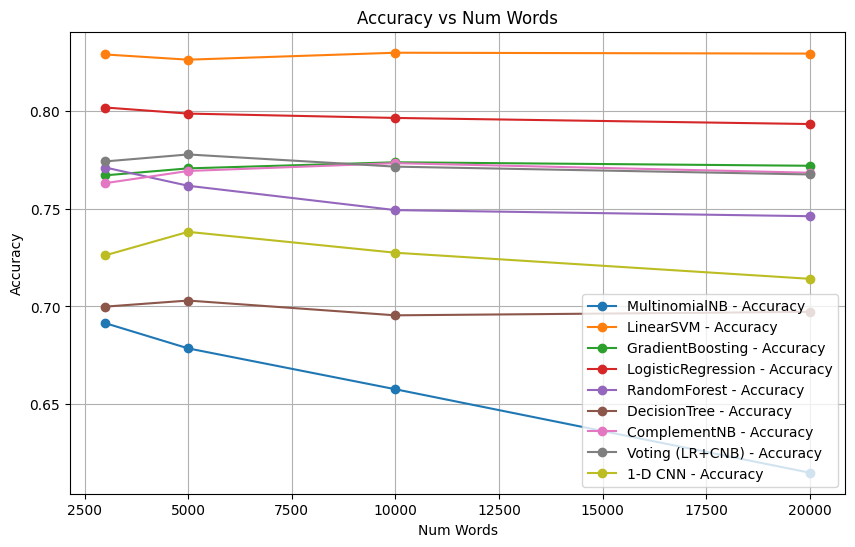

In [ ]:
# Acc
draw_metric_grid(final_df, 'Accuracy', n_cols=3)

plt.figure(figsize=(10,6))
for model_name in final_df["Model"].unique():
    subset = final_df[final_df["Model"] == model_name]
    plt.plot(subset["Num Words"], subset["Accuracy"], marker='o', label=f"{model_name} - Accuracy")

plt.title("Accuracy vs Num Words")
plt.xlabel("Num Words")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

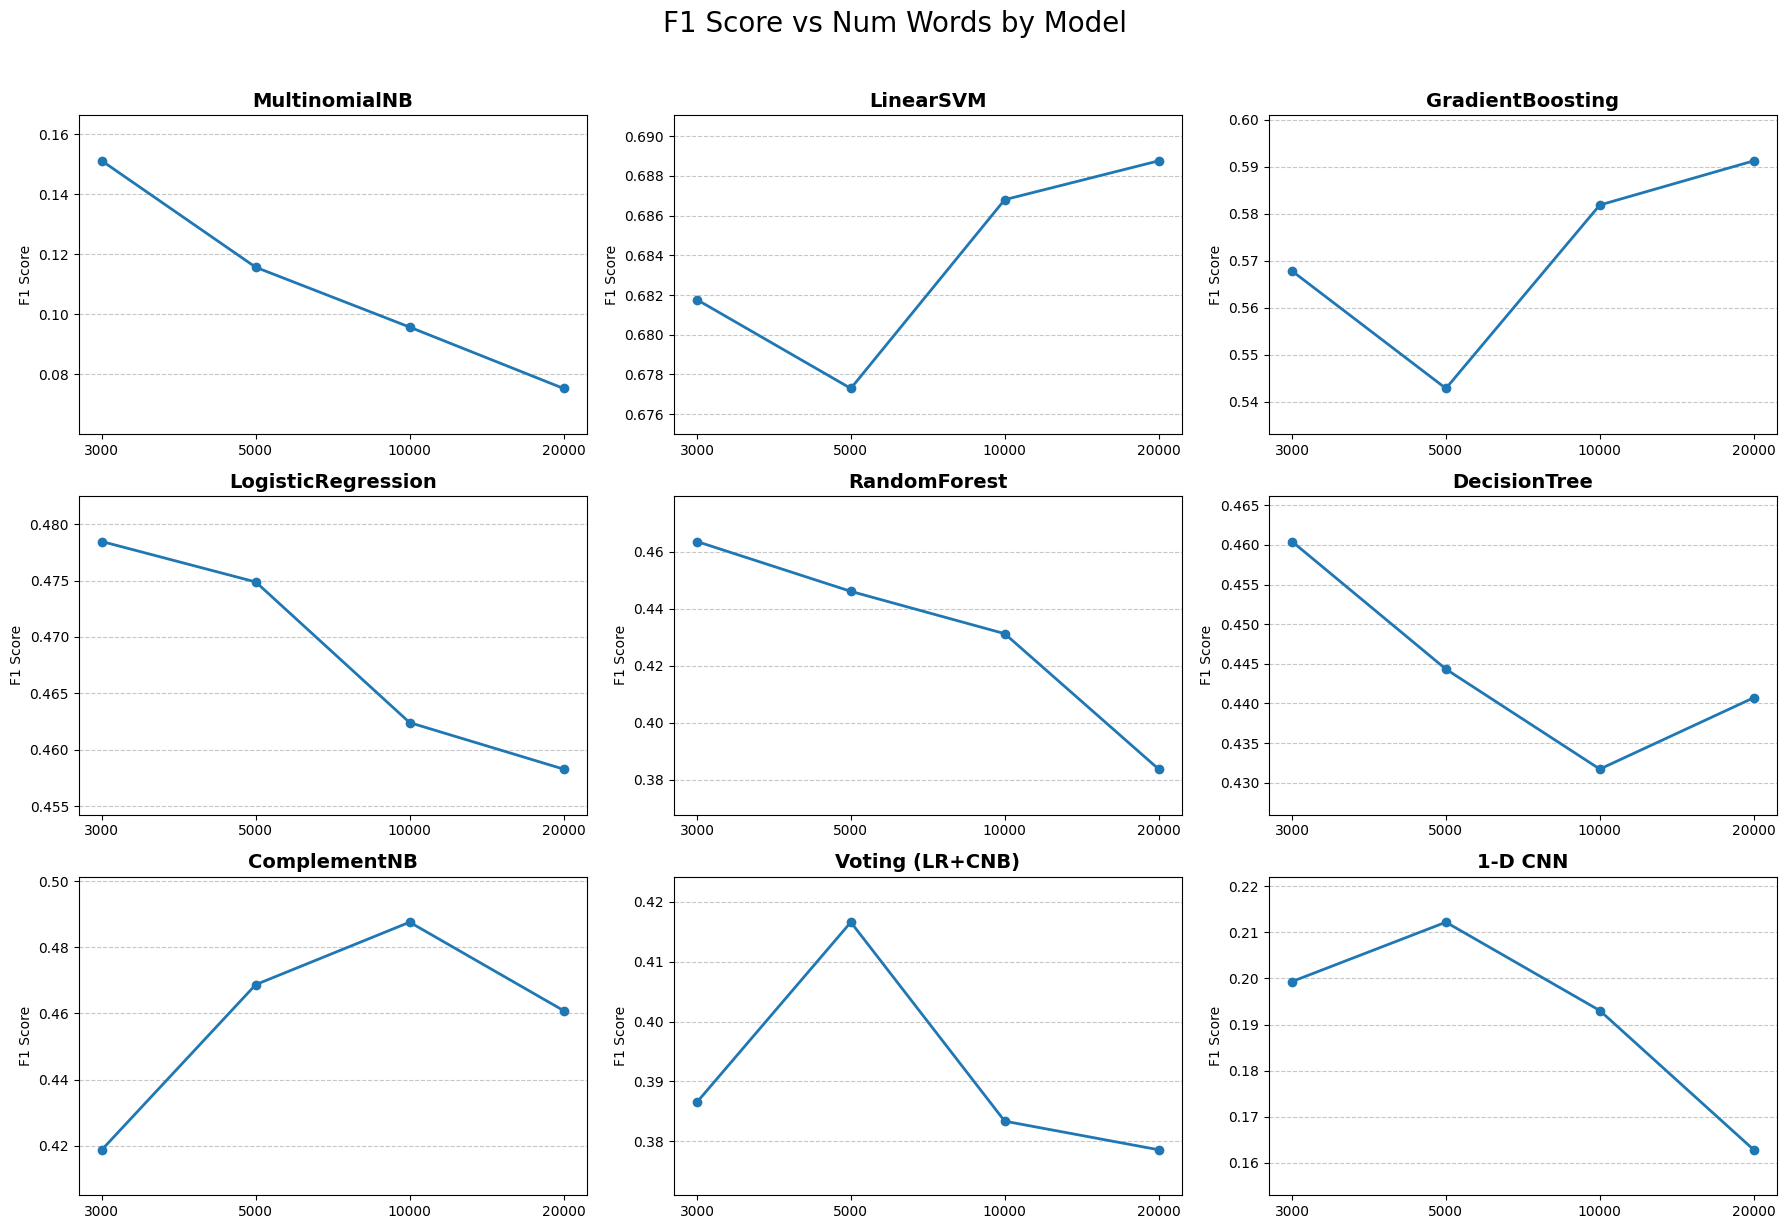

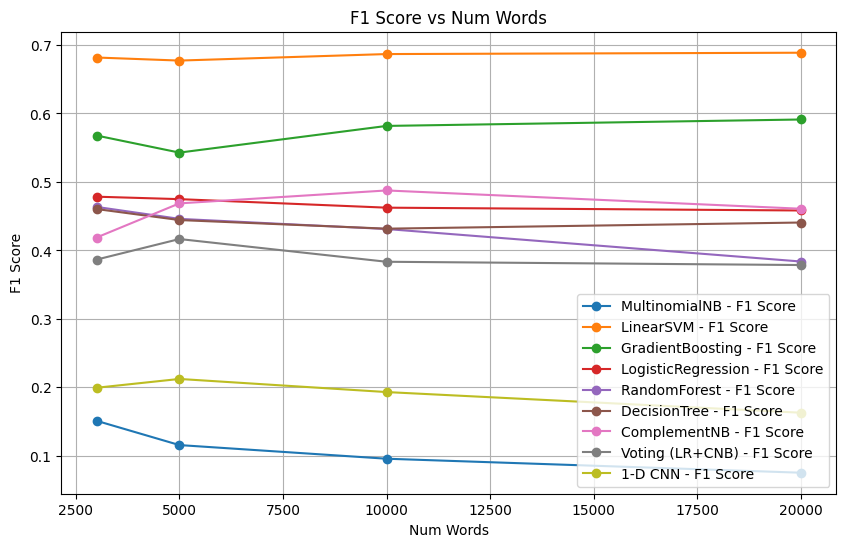

In [ ]:
# F1 score
draw_metric_grid(final_df, 'F1 Score', n_cols=3)

plt.figure(figsize=(10,6))
for model_name in final_df["Model"].unique():
    subset = final_df[final_df["Model"] == model_name]
    plt.plot(subset["Num Words"], subset["F1 Score"], marker='o', label=f"{model_name} - F1 Score")

plt.title("F1 Score vs Num Words")
plt.xlabel("Num Words")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.show()

- 두 지표 모두에서 가장 좋은 결과를 보이는 모델은 LinearSVM이다.  
- 두 지표 모두에서 가장 안 좋은 결과를 보이는 모델은 MultinomialNB이며, num_words가 커질수록 성능이 크게 하락하는 경향이 있다.  

<br>

LinearSVM 모델이 가장 좋은 성능을 보이는 이유:  
- 선형모델은 TF_IDF 같은 차원이 크고 sparse한 데이터 분류에 강건하다는 특징이 있다.  
- 중요한 단어에 가중치를 부여하고, 노이즈에 강하기 때문에 num_words가 늘어나도 성능이 안정적으로 유지된다.(그래프에서도 볼 수 있듯이 어휘 크기가 10,000 -> 20,000으로 늘어나면 오히려 F1 score가 높아진다.)  
<br>

num_words가 늘어날수록 MultinomialNB 모델의 Acc가 계속 하락하는 이유:  
- 단어 수가 많아질수록 무의미한 단어들의 확률값이 누적되어 예측력을 떨어뜨리기 때문이다.  
<br>

1D CNN의 Acc와 F1 score가 낮은 이유:  
- 1D CNN은 num_words=5000일 때 최적의 성능을 보이며, epoch가 적어서 그런지 기대만큼 좋은 성능을 보이지는 못 한다.  
<br>

num_words가 커질수록 성능이 낮아지는 모델들의 원인은, num_words가 커질수록 TF-IDF 차원이 커지게 되고, 노이즈가 많아지기 때문이라고 생각한다.  


# 1D CNN의 epoch 늘리기
50

In [ ]:
import time
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score
import tensorflow as tf

# 데이터셋의 클래스 개수 확인
num_classes = len(np.unique(y_train))
print(f"데이터 확인 완료. 총 클래스 개수: {num_classes}")

# GPU 사용 가능 여부 확인
print("GPU Available:", tf.config.list_physical_devices('GPU'))


# --- 실험 설정 ---
num_words_list = [3000, 5000, 10000, 20000]
results = []

# 하이퍼파라미터
EMBEDDING_DIM = 128
MAXLEN = 150
CNN_EPOCHS = 50
CNN_BATCH_SIZE = 64


# --- 학습 루프 ---
for num_words in num_words_list:
    print(f"\n{'='*15} num_words = {num_words} {'='*15}")
    loop_start_time = time.time()

    print(f"[INFO] 1-D CNN 모델 학습 시작...")

    # 1. 토큰화 및 패딩
    tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(train_texts_all)

    X_train_seq = tokenizer.texts_to_sequences(train_texts_all)
    X_test_seq = tokenizer.texts_to_sequences(test_texts_all)

    X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=MAXLEN)
    X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=MAXLEN)

    # 2. 레이블 원-핫 인코딩
    y_train_cat = to_categorical(y_train, num_classes=num_classes)
    y_test_cat = to_categorical(y_test, num_classes=num_classes)

    # 3. 모델 정의 함수
    def create_cnn_model(vocab_size, embedding_dim, maxlen, num_classes):
        model = Sequential([
            Embedding(input_dim=vocab_size,
                      output_dim=embedding_dim),
            Dropout(0.3),
            Conv1D(128, 5, activation='relu'),
            GlobalMaxPooling1D(),
            Dense(64, activation='relu'),
            Dropout(0.4),
            Dense(num_classes, activation='softmax')
        ])
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

    # 4. 모델 생성 및 학습
    model_cnn = create_cnn_model(num_words, EMBEDDING_DIM, MAXLEN, num_classes)

    # EarlyStopping 설정
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    history = model_cnn.fit(
        X_train_pad, y_train_cat,
        epochs=CNN_EPOCHS,
        batch_size=CNN_BATCH_SIZE,
        validation_split=0.1,
        callbacks=[early_stopping],
        verbose=1
    )

    # 5. 평가
    print("\n[INFO] 평가 진행 중...")
    preds_proba_cnn = model_cnn.predict(X_test_pad, verbose=0)
    preds_cnn = np.argmax(preds_proba_cnn, axis=1)

    acc_cnn = accuracy_score(y_test, preds_cnn)
    f1_cnn = f1_score(y_test, preds_cnn, average="macro")

    results.append([num_words, "1-D CNN", acc_cnn, f1_cnn])

    elapsed = time.time() - loop_start_time
    print(f"Completed! Acc: {acc_cnn:.4f}, F1: {f1_cnn:.4f} (Time: {elapsed:.1f}s)")


# --- 최종 결과 출력 ---
print("\n\n" + "="*40)
print("      Total Experiment Results")
print("="*40)

df_results = pd.DataFrame(results, columns=["Num Words", "Model", "Accuracy", "F1 Score"])
df_results = df_results.sort_values(by=["Num Words", "F1 Score"], ascending=[True, False])
print(df_results.to_string(index=False, float_format="%.4f"))

데이터 확인 완료. 총 클래스 개수: 46
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

=============== num_words = 3000 ===============
[INFO] 1-D CNN 모델 학습 시작...
Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.3413 - loss: 2.8746 - val_accuracy: 0.4939 - val_loss: 1.9220
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5530 - loss: 1.8376 - val_accuracy: 0.6696 - val_loss: 1.4770
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6730 - loss: 1.4387 - val_accuracy: 0.6885 - val_loss: 1.3060
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7024 - loss: 1.2471 - val_accuracy: 0.7041 - val_loss: 1.2104
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7422 - loss: 1.0730 - val_accuracy: 0.7208 - val_loss: 1.1495
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7763 - loss: 0.9335 - val_accuracy: 0.7341 - val_loss: 1.1103
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/s

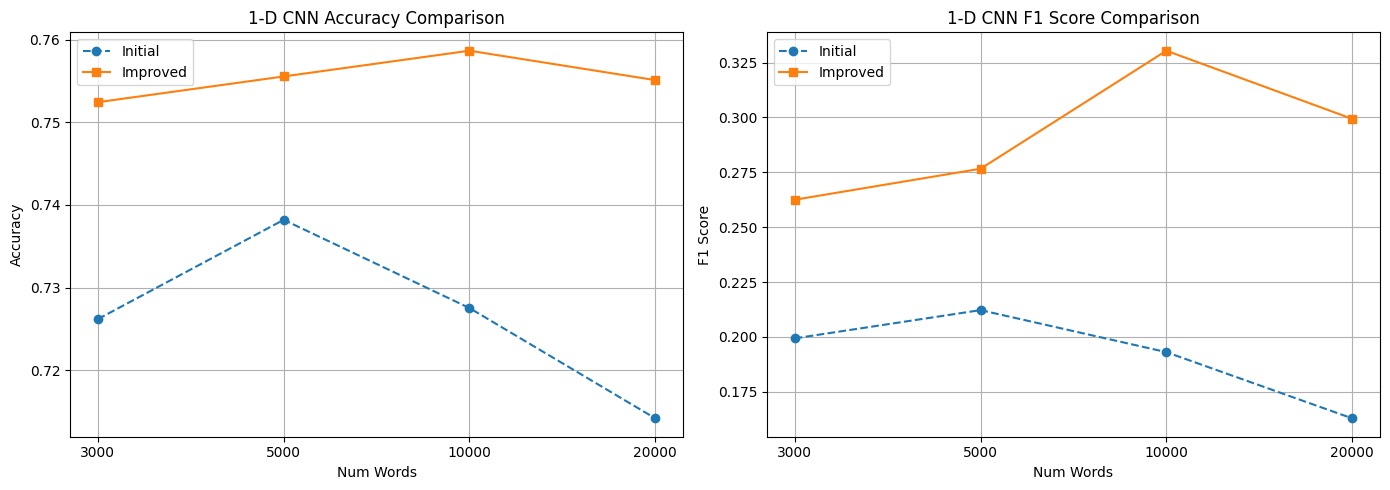

In [ ]:
final_df_cnn = final_df[final_df['Model'] == "1-D CNN"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy 비교
axes[0].plot(final_df_cnn['Num Words'].astype(str), final_df_cnn['Accuracy'], marker='o', linestyle='--', label='Initial')
axes[0].plot(df_results['Num Words'].astype(str), df_results['Accuracy'], marker='s', linestyle='-', label='Improved')
axes[0].set_title('1-D CNN Accuracy Comparison')
axes[0].set_xlabel('Num Words')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# F1 Score 비교
axes[1].plot(final_df_cnn['Num Words'].astype(str), final_df_cnn['F1 Score'], marker='o', linestyle='--', label='Initial')
axes[1].plot(df_results['Num Words'].astype(str), df_results['F1 Score'], marker='s', linestyle='-', label='Improved')
axes[1].set_title('1-D CNN F1 Score Comparison')
axes[1].set_xlabel('Num Words')
axes[1].set_ylabel('F1 Score')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

Epoch를 50으로 늘리니 전체적인 성능이 향상됐고, num_words가 늘어도 성능이 크게 하락하던 기존 CNN과 달리 어느정도 안정적인 모습을 보여준다.

In [ ]:
# Acc
draw_metric_grid(final_df, 'Accuracy', n_cols=3)

plt.figure(figsize=(10,6))
for model_name in final_df["Model"].unique():
    subset = final_df[final_df["Model"] == model_name]
    plt.plot(subset["Num Words"], subset["Accuracy"], marker='o', label=f"{model_name} - Accuracy")

plt.title("Accuracy vs Num Words")
plt.xlabel("Num Words")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

✓ 데이터 로드 완료!
  - 전체: 52 행
  - 모델: 9개
  - Vocab 크기: [np.int64(1000), np.int64(3000), np.int64(5000), np.int64(10000), np.int64(20000), np.int64(30000)]



/tmp/ipython-input-3492975908.py:50: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3492975908.py:50: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3492975908.py:50: UserWarning: Glyph 46304 (\N{HANGUL SYLLABLE DEUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3492975908.py:50: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3492975908.py:50: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3492975908.py:50: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3492975908.py:50: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipytho

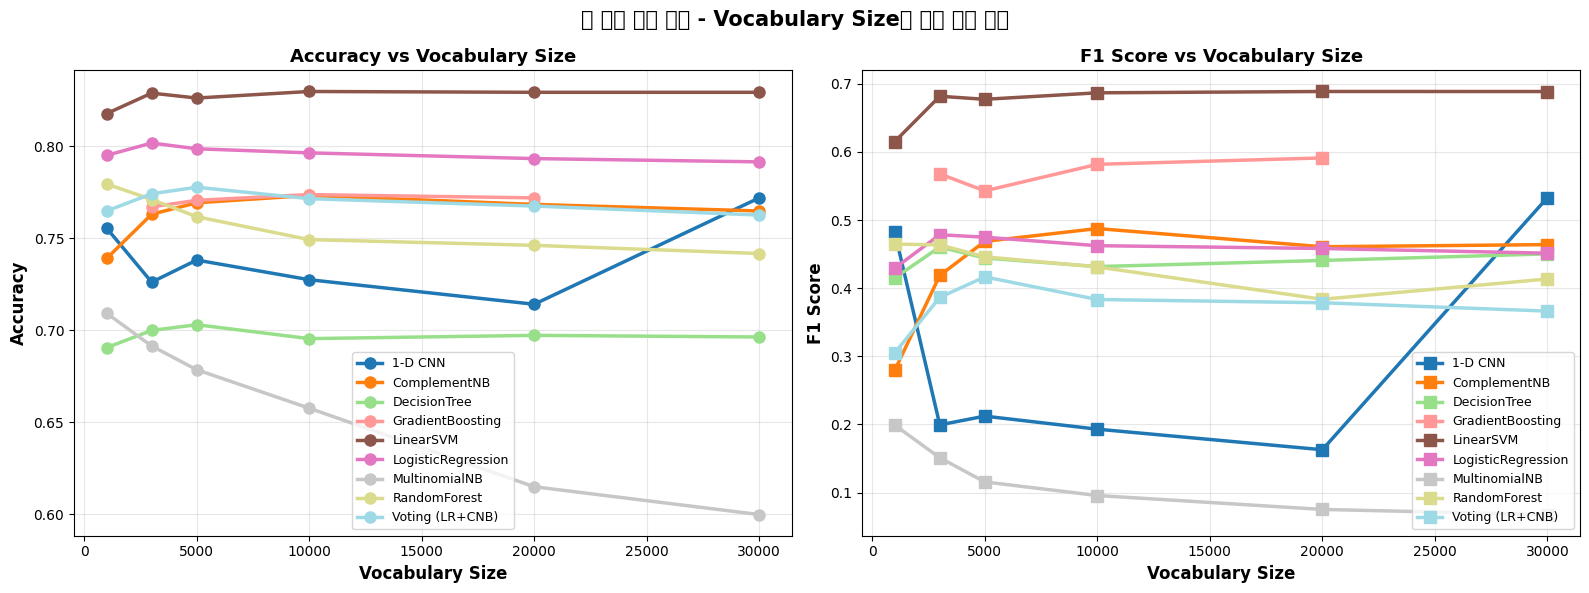

/tmp/ipython-input-3492975908.py:83: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3492975908.py:83: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3492975908.py:83: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3492975908.py:83: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3492975908.py:83: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3492975908.py:83: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3492975908.py:83: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  plt.t

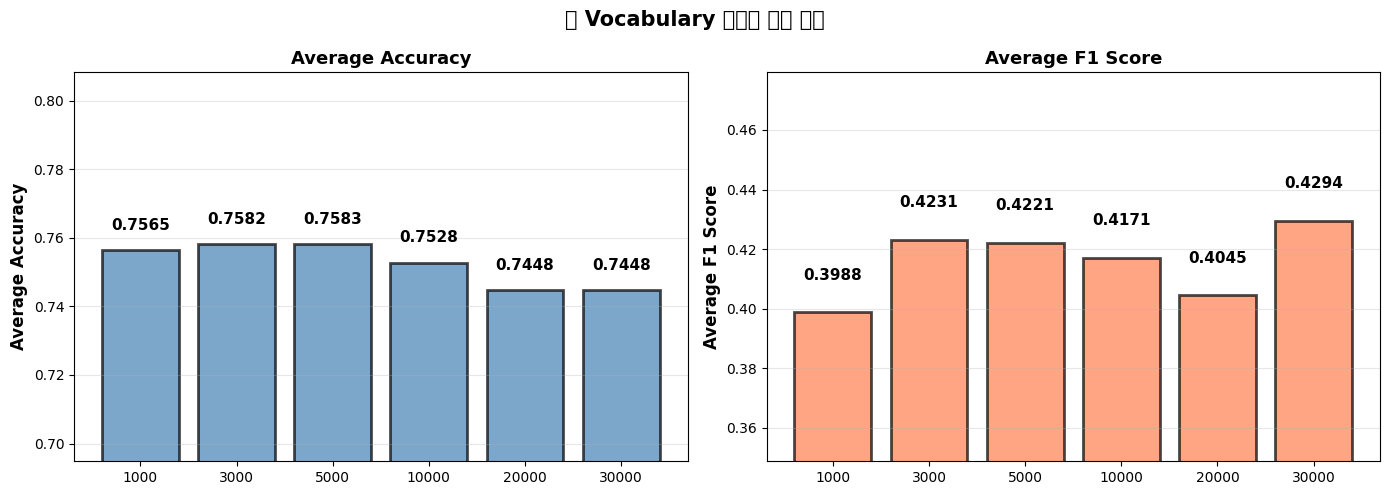

/tmp/ipython-input-3492975908.py:127: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3492975908.py:127: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3492975908.py:127: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3492975908.py:127: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3492975908.py:127: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3492975908.py:127: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3492975908.py:127: UserWarning: Glyph 55176 (\N{HANGUL SYLLABLE HI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/t

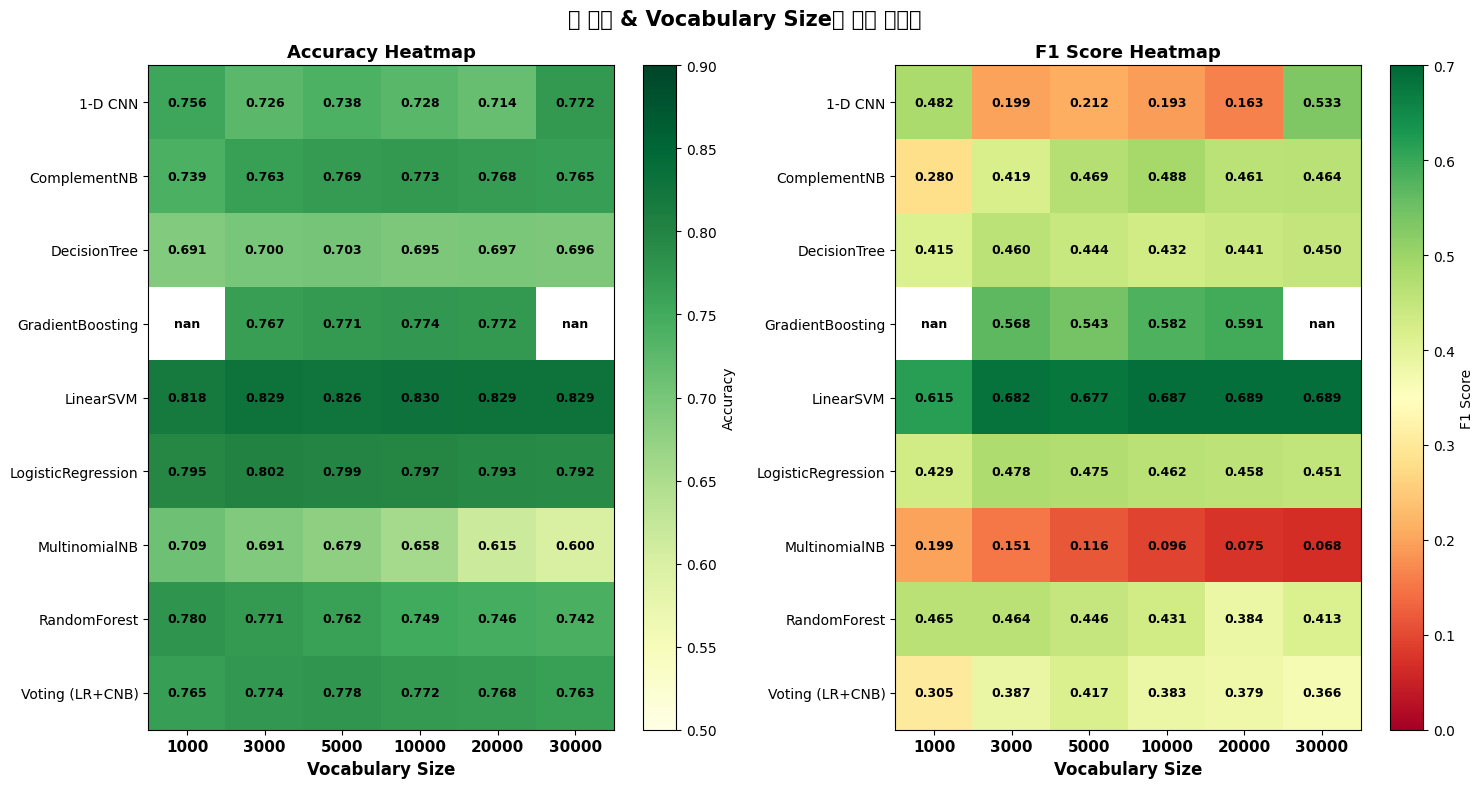


📋 모델별 상세 성능 분석

📌 1-D CNN
----------------------------------------------------------------------
  Vocab  1000 → Accuracy: 0.7556 | F1 Score: 0.4819
  Vocab  3000 → Accuracy: 0.7262 | F1 Score: 0.1993
  Vocab  5000 → Accuracy: 0.7382 | F1 Score: 0.2122
  Vocab 10000 → Accuracy: 0.7275 | F1 Score: 0.1930
  Vocab 20000 → Accuracy: 0.7142 | F1 Score: 0.1629
  Vocab 30000 → Accuracy: 0.7720 | F1 Score: 0.5329
  변화: Accuracy +0.0165 (+2.18%) | F1 +0.0509 (+10.57%)

📌 ComplementNB
----------------------------------------------------------------------
  Vocab  1000 → Accuracy: 0.7391 | F1 Score: 0.2796
  Vocab  3000 → Accuracy: 0.7631 | F1 Score: 0.4188
  Vocab  5000 → Accuracy: 0.7694 | F1 Score: 0.4687
  Vocab 10000 → Accuracy: 0.7734 | F1 Score: 0.4876
  Vocab 20000 → Accuracy: 0.7685 | F1 Score: 0.4608
  Vocab 30000 → Accuracy: 0.7649 | F1 Score: 0.4640
  변화: Accuracy +0.0258 (+3.49%) | F1 +0.1844 (+65.96%)

📌 DecisionTree
-----------------------------------------------------------------

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

# 두 데이터셋 로드
ml_models_df = pd.read_csv('/content/ML_models.csv')
vocab_df = pd.read_csv('/content/vocab_1000_30000.csv')

# 데이터 합치기
combined_df = pd.concat([ml_models_df, vocab_df], ignore_index=True)
combined_df = combined_df.sort_values(['Model', 'Num Words']).reset_index(drop=True)

print("✓ 데이터 로드 완료!")
print(f"  - 전체: {len(combined_df)} 행")
print(f"  - 모델: {combined_df['Model'].nunique()}개")
print(f"  - Vocab 크기: {sorted(combined_df['Num Words'].unique())}\n")

# ==================== 1. 모든 모델 한눈에 보기 ====================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("📊 모든 모델 비교 - Vocabulary Size에 따른 성능 변화", fontsize=15, fontweight='bold')

models = sorted(combined_df['Model'].unique())
colors = cm.tab20(np.linspace(0, 1, len(models)))

# Accuracy
ax1 = axes[0]
for idx, model in enumerate(models):
    data = combined_df[combined_df['Model'] == model].sort_values('Num Words')
    ax1.plot(data['Num Words'], data['Accuracy'], marker='o', linewidth=2.5,
             markersize=8, label=model, color=colors[idx])
ax1.set_xlabel('Vocabulary Size', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Accuracy vs Vocabulary Size', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=9)
ax1.grid(True, alpha=0.3)

# F1 Score
ax2 = axes[1]
for idx, model in enumerate(models):
    data = combined_df[combined_df['Model'] == model].sort_values('Num Words')
    ax2.plot(data['Num Words'], data['F1 Score'], marker='s', linewidth=2.5,
             markersize=8, label=model, color=colors[idx])
ax2.set_xlabel('Vocabulary Size', fontsize=12, fontweight='bold')
ax2.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
ax2.set_title('F1 Score vs Vocabulary Size', fontsize=13, fontweight='bold')
ax2.legend(loc='best', fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ==================== 2. 평균 성능 비교 ====================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("📈 Vocabulary 크기별 평균 성능", fontsize=15, fontweight='bold')

vocab_sizes = sorted(combined_df['Num Words'].unique())

# 평균 Accuracy
ax1 = axes[0]
avg_acc = [combined_df[combined_df['Num Words'] == v]['Accuracy'].mean() for v in vocab_sizes]
bars1 = ax1.bar([str(v) for v in vocab_sizes], avg_acc, color='steelblue', alpha=0.7, edgecolor='black', linewidth=2)
for bar, val in zip(bars1, avg_acc):
    ax1.text(bar.get_x() + bar.get_width()/2, val + 0.005, f'{val:.4f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')
ax1.set_ylabel('Average Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Average Accuracy', fontsize=13, fontweight='bold')
ax1.set_ylim([min(avg_acc) - 0.05, max(avg_acc) + 0.05])
ax1.grid(axis='y', alpha=0.3)

# 평균 F1 Score
ax2 = axes[1]
avg_f1 = [combined_df[combined_df['Num Words'] == v]['F1 Score'].mean() for v in vocab_sizes]
bars2 = ax2.bar([str(v) for v in vocab_sizes], avg_f1, color='coral', alpha=0.7, edgecolor='black', linewidth=2)
for bar, val in zip(bars2, avg_f1):
    ax2.text(bar.get_x() + bar.get_width()/2, val + 0.01, f'{val:.4f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')
ax2.set_ylabel('Average F1 Score', fontsize=12, fontweight='bold')
ax2.set_title('Average F1 Score', fontsize=13, fontweight='bold')
ax2.set_ylim([min(avg_f1) - 0.05, max(avg_f1) + 0.05])
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ==================== 3. 모델별 히트맵 ====================
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
fig.suptitle("🔥 모델 & Vocabulary Size별 성능 히트맵", fontsize=15, fontweight='bold')

# Accuracy 히트맵
pivot_acc = combined_df.pivot_table(values='Accuracy', index='Model', columns='Num Words', aggfunc='mean')
pivot_acc = pivot_acc[sorted(pivot_acc.columns)]

im1 = axes[0].imshow(pivot_acc.values, cmap='YlGn', aspect='auto', vmin=0.5, vmax=0.9)
axes[0].set_xticks(range(len(pivot_acc.columns)))
axes[0].set_xticklabels(pivot_acc.columns, fontsize=11, fontweight='bold')
axes[0].set_yticks(range(len(pivot_acc.index)))
axes[0].set_yticklabels(pivot_acc.index, fontsize=10)
axes[0].set_xlabel('Vocabulary Size', fontsize=12, fontweight='bold')
axes[0].set_title('Accuracy Heatmap', fontsize=13, fontweight='bold')

for i in range(len(pivot_acc.index)):
    for j in range(len(pivot_acc.columns)):
        axes[0].text(j, i, f'{pivot_acc.values[i, j]:.3f}',
                    ha="center", va="center", color="black", fontsize=9, fontweight='bold')

plt.colorbar(im1, ax=axes[0], label='Accuracy')

# F1 Score 히트맵
pivot_f1 = combined_df.pivot_table(values='F1 Score', index='Model', columns='Num Words', aggfunc='mean')
pivot_f1 = pivot_f1[sorted(pivot_f1.columns)]

im2 = axes[1].imshow(pivot_f1.values, cmap='RdYlGn', aspect='auto', vmin=0, vmax=0.7)
axes[1].set_xticks(range(len(pivot_f1.columns)))
axes[1].set_xticklabels(pivot_f1.columns, fontsize=11, fontweight='bold')
axes[1].set_yticks(range(len(pivot_f1.index)))
axes[1].set_yticklabels(pivot_f1.index, fontsize=10)
axes[1].set_xlabel('Vocabulary Size', fontsize=12, fontweight='bold')
axes[1].set_title('F1 Score Heatmap', fontsize=13, fontweight='bold')

for i in range(len(pivot_f1.index)):
    for j in range(len(pivot_f1.columns)):
        axes[1].text(j, i, f'{pivot_f1.values[i, j]:.3f}',
                    ha="center", va="center", color="black", fontsize=9, fontweight='bold')

plt.colorbar(im2, ax=axes[1], label='F1 Score')
plt.tight_layout()
plt.show()

# ==================== 4. 개별 모델 상세 분석 ====================
print("\n" + "="*70)
print("📋 모델별 상세 성능 분석")
print("="*70 + "\n")

for model in models:
    model_data = combined_df[combined_df['Model'] == model].sort_values('Num Words')

    print(f"📌 {model}")
    print("-" * 70)

    for _, row in model_data.iterrows():
        print(f"  Vocab {row['Num Words']:>5} → Accuracy: {row['Accuracy']:.4f} | F1 Score: {row['F1 Score']:.4f}")

    if len(model_data) > 1:
        acc_change = model_data['Accuracy'].iloc[-1] - model_data['Accuracy'].iloc[0]
        f1_change = model_data['F1 Score'].iloc[-1] - model_data['F1 Score'].iloc[0]
        print(f"  변화: Accuracy {acc_change:+.4f} ({acc_change/model_data['Accuracy'].iloc[0]*100:+.2f}%) | "
              f"F1 {f1_change:+.4f} ({f1_change/model_data['F1 Score'].iloc[0]*100:+.2f}%)")
    print()

# ==================== 5. 최종 요약 ====================
print("="*70)
print("🏆 최종 통계")
print("="*70)

print("\n✓ 모델별 평균 성능 (Accuracy 기준 정렬):")
model_summary = combined_df.groupby('Model')[['Accuracy', 'F1 Score']].mean().sort_values('Accuracy', ascending=False)
for i, (model, row) in enumerate(model_summary.iterrows(), 1):
    print(f"  {i}. {model:25} → Accuracy: {row['Accuracy']:.4f} | F1: {row['F1 Score']:.4f}")

print("\n✓ Vocabulary 크기별 평균 성능:")
vocab_summary = combined_df.groupby('Num Words')[['Accuracy', 'F1 Score']].mean()
for vocab_size, row in vocab_summary.iterrows():
    print(f"  Vocab {vocab_size:>5} → Accuracy: {row['Accuracy']:.4f} | F1: {row['F1 Score']:.4f}")

print("\n✓ 전체 최고 성능:")
best_acc_row = combined_df.loc[combined_df['Accuracy'].idxmax()]
best_f1_row = combined_df.loc[combined_df['F1 Score'].idxmax()]
print(f"  최고 Accuracy: {best_acc_row['Accuracy']:.4f} ({best_acc_row['Model']}, Vocab: {int(best_acc_row['Num Words'])})")
print(f"  최고 F1 Score: {best_f1_row['F1 Score']:.4f} ({best_f1_row['Model']}, Vocab: {int(best_f1_row['Num Words'])})")